# TensorBoard損失プロット (dam-break-left-100)
rootに置かれたTensorBoardログ (`events.out.tfevents.*`) から train/valid の損失を可視化します。


In [2]:
from pathlib import Path
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
%matplotlib inline

# ログファイルを自動検出（更新日時の新しいものを使用）
log_files = sorted(Path('.').glob('events.out.tfevents.*'), key=lambda p: p.stat().st_mtime, reverse=True)
assert log_files, 'TensorBoardイベントファイルが見つかりませんでした'
log_file = log_files[0]
print(f'使用ログ: {log_file}')

ea = EventAccumulator(str(log_file))
ea.Reload()
print('scalar tags:', ea.Tags().get('scalars', []))


使用ログ: events.out.tfevents.1769257828.67dfc2b552d0.64.0
scalar tags: ['train/loss', 'train/lr', 'system/step_time_sec', 'system/samples_per_sec', 'system/gpu_util', 'system/gpu_mem_used_mb', 'system/gpu_mem_total_mb', 'train/grad_norm_pre_clip', 'train/grad_norm', 'epoch/valid_loss', 'epoch/train_loss', 'valid/loss']


In [3]:
def get_scalars(ea, tag):
    events = ea.Scalars(tag)
    return [e.step for e in events], [e.value for e in events]

train_steps, train_loss = get_scalars(ea, 'train/loss')
valid_steps, valid_loss = get_scalars(ea, 'valid/loss')

epoch_train = epoch_valid = None
if 'epoch/train_loss' in ea.Tags().get('scalars', []):
    epoch_train = get_scalars(ea, 'epoch/train_loss')
if 'epoch/valid_loss' in ea.Tags().get('scalars', []):
    epoch_valid = get_scalars(ea, 'epoch/valid_loss')

# 先頭数件を確認
print('train/loss sample:', list(zip(train_steps, train_loss))[:3])
print('valid/loss sample:', list(zip(valid_steps, valid_loss))[:3])


train/loss sample: [(500, 1.0518423318862915), (1000, 0.28197354078292847), (1500, 0.27062514424324036)]
valid/loss sample: [(1000, 0.18331573903560638), (1000, 0.18331573903560638), (1500, 0.1294408142566681)]


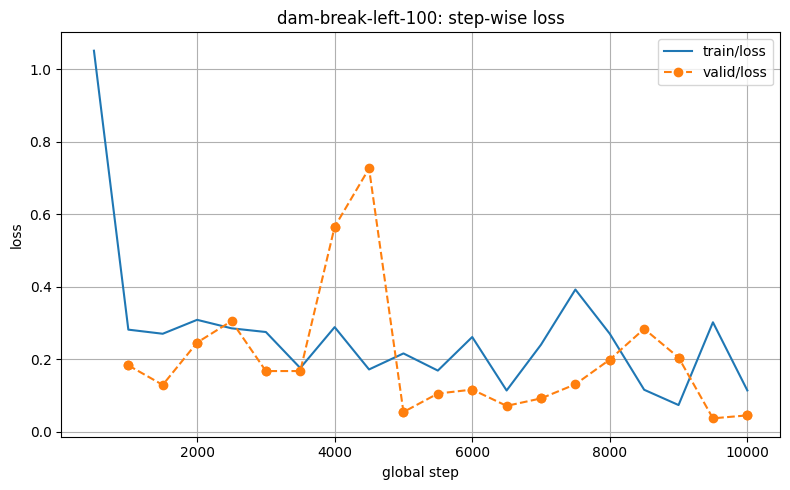

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_steps, train_loss, label='train/loss')
ax.plot(valid_steps, valid_loss, label='valid/loss', marker='o', linestyle='--')
ax.set_xlabel('global step')
ax.set_ylabel('loss')
ax.set_title('dam-break-left-100: step-wise loss')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


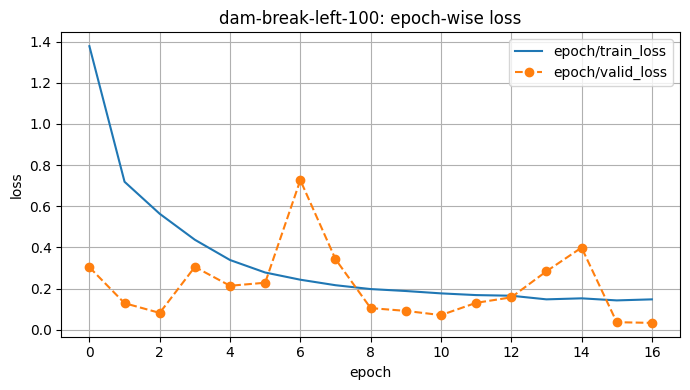

In [5]:
if epoch_train and epoch_valid:
    (e_train_steps, e_train_loss) = epoch_train
    (e_valid_steps, e_valid_loss) = epoch_valid
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(e_train_steps, e_train_loss, label='epoch/train_loss')
    ax.plot(e_valid_steps, e_valid_loss, label='epoch/valid_loss', marker='o', linestyle='--')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title('dam-break-left-100: epoch-wise loss')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print('epoch単位のスカラーが見つかりませんでした')


依存は `tensorboard` と `matplotlib` のみ（`pandas` 不要）。別ログを使う場合は `log_files` のフィルタや `log_file` 変数を変更してください。
